# 03: Simplified Floating

In this example, we run `Ard` on a simplified floating platform problem.

We follow Example 02 closely, so descriptions are more sparse.

In [1]:
from pathlib import Path  # optional, for nice path specifications

import pprint as pp  # optional, for nice printing
import numpy as np  # numerics library
import matplotlib.pyplot as plt  # plotting capabilities

import windIO

import ard  # technically we only really need this
from ard.utils.io import load_yaml  # we grab a yaml loader here
from ard.api import set_up_ard_model  # the secret sauce
from ard.viz.layout import plot_layout  # a plotting tool!

import openmdao.api as om  # for N2 diagrams from the OpenMDAO backend

# import optiwindnet.plotting

%matplotlib inline

In [2]:
# load input
path_inputs = Path.cwd().absolute() / "inputs"
input_dict = load_yaml(path_inputs / "ard_system.yaml")

# set up system
prob = set_up_ard_model(input_dict=input_dict, root_data_path=path_inputs)

floris.floris_model.FlorisModel WARNING turbine_type has been changed without specifying a new reference_wind_height. reference_wind_height remains 90.00 m. Consider calling `FlorisModel.assign_hub_height_to_ref_height` to update the reference wind height to the turbine hub height.


Adding top_level
Adding layout2aep
Adding layout to layout2aep
Adding aepFLORIS to layout2aep
	Activating approximate totals on layout2aep
Adding landuse
Adding collection
Adding mooring_design
Adding mooring_constraint
Adding spacing_constraint
Adding tcc
Adding orbit
Adding opex
Adding financese


Some new components are added to the `Ard` model here, comparing to Example 02:
- `mooring_design`: designs the mooring system, here simply by doing straight-line mooring lines to the constant-valued seafloor
- `mooring_constraint`: a module to compute a constraint function to make sure the moorings don't violate regulatory requirements on proximity

In [3]:
# visualize model
if False:
    om.n2(prob)

In [4]:
# run the model
prob.run_model()

# collapse the test result data
test_data = {
    "AEP_val": float(prob.get_val("AEP_farm", units="GW*h")[0]),
    "CapEx_val": float(prob.get_val("tcc.tcc", units="MUSD")[0]),
    "BOS_val": float(prob.get_val("orbit.total_capex", units="MUSD")[0]),
    "OpEx_val": float(prob.get_val("opex.opex", units="MUSD/yr")[0]),
    "LCOE_val": float(prob.get_val("financese.lcoe", units="USD/MW/h")[0]),
    "area_tight": float(prob.get_val("landuse.area_tight", units="km**2")[0]),
    "coll_length": float(
        prob.get_val("collection.total_length_cables", units="km")[0]
    ),
    "mooring_spacing": float(
        np.min(prob.get_val("mooring_constraint.mooring_spacing", units="km"))
    ),
    "turbine_spacing": float(
        np.min(prob.get_val("spacing_constraint.turbine_spacing", units="km"))
    ),
}

print("\n\nRESULTS:\n")
pp.pprint(test_data)
print("\n\n")

/Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/openmdao/recorders/sqlite_recorder.py:231: UserWarning:The existing case recorder file, ard_prob_out/problem_out/opt_results.sql, is being overwritten.
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

ORBIT library intialized at '/Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/library'


RESULTS:

{'AEP_val': 409.5574721457793,
 'BOS_val': 992.9941014540512,
 'CapEx_val': 118.75948972475001,
 'LCOE_val': 226.41881944569417,
 'OpEx_val': 9.350000000000001,
 'area_tight': 13.2496,
 'coll_length': 21.89865877023397,
 'mooring_spacing': 0.042875983926893214,
 'turbine_spacing': 0.91}





Driver debug print for iter coord: rank0:ScipyOptimize_SLSQP|0
--------------------------------------------------------------
Design Vars
{'angle_orientation': array([0.]),
 'angle_skew': array([0.]),
 'spacing_primary': array([7.]),
 'spacing_secondary': array([7.])}



invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_deflection/gauss.py:163
invalid value encountered in divideRuntimeWarning: /Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/floris/core/wake_velocity/gauss.py:80
invalid value encountered in divide

Objectives
{'collection.total_length_cables': array([21898.65877023])}

Driver debug print for iter coord: rank0:ScipyOptimize_SLSQP|1
--------------------------------------------------------------
Design Vars
{'angle_orientation': array([0.]),
 'angle_skew': array([0.]),
 'spacing_primary': array([7.]),
 'spacing_secondary': array([7.])}

Objectives
{'collection.total_length_cables': array([21898.65877023])}

Driver debug print for iter coord: rank0:ScipyOptimize_SLSQP|2
--------------------------------------------------------------
Design Vars
{'angle_orientation': array([0.00109214]),
 'angle_skew': array([-0.00134399]),
 'spacing_primary': array([6.98051224]),
 'spacing_secondary': array([6.98052015])}

Objectives
{'collection.total_length_cables': array([21837.91155865])}

Driver debug print for iter coord: rank0:ScipyOptimize_SLSQP|3
--------------------------------------------------------------
Design Vars
{'angle_orientation': array([-0.00014881]),
 'angle_skew': array([-0.0063

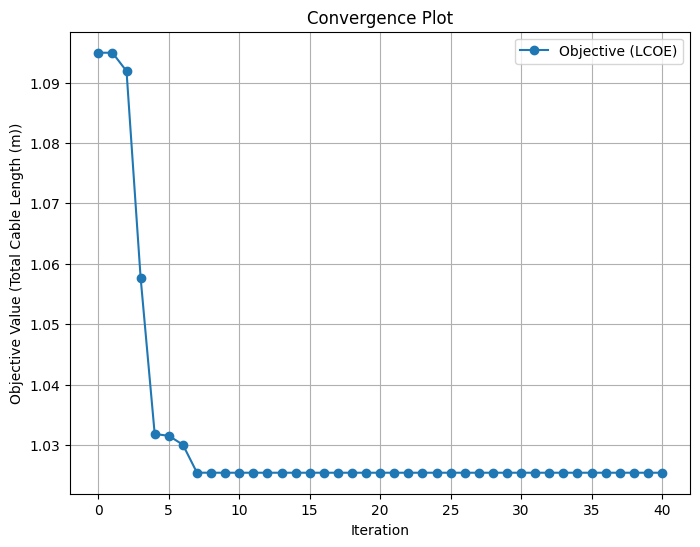

In [5]:
optimize = True  # set to False to skip optimization
if optimize:
    # run the optimization
    prob.run_driver()
    prob.cleanup()

    prob.check_totals(compact_print=True, show_only_incorrect=True)

    # collapse the test result data
    test_data = {
        "spacing_primary": float(prob.get_val("spacing_primary")[0]),
        "spacing_secondary": float(prob.get_val("spacing_secondary")[0]),
        "angle_orientation": float(prob.get_val("angle_orientation")[0]),
        "angle_skew": float(prob.get_val("angle_skew")[0]),
        "AEP_val": float(prob.get_val("AEP_farm", units="GW*h")[0]),
        "CapEx_val": float(prob.get_val("tcc.tcc", units="MUSD")[0]),
        "BOS_val": float(prob.get_val("orbit.total_capex", units="MUSD")[0]),
        "OpEx_val": float(prob.get_val("opex.opex", units="MUSD/yr")[0]),
        "LCOE_val": float(prob.get_val("financese.lcoe", units="USD/MW/h")[0]),
        "area_tight": float(prob.get_val("landuse.area_tight", units="km**2")[0]),
        "coll_length": float(
            prob.get_val("collection.total_length_cables", units="km")[0]
        ),
        "mooring_spacing": float(
            np.min(prob.get_val("mooring_constraint.mooring_spacing", units="km"))
        ),
        "turbine_spacing": float(
            np.min(prob.get_val("spacing_constraint.turbine_spacing", units="km"))
        ),
    }

    # clean up the recorder
    prob.cleanup()

    # print the results
    print("\n\nRESULTS (opt):\n")
    pp.pprint(test_data)
    print("\n\n")

    # plot convergence
    ## read cases
    cr = om.CaseReader(
        prob.get_outputs_dir()
        / input_dict["analysis_options"]["recorder"]["filepath"]
    )

    # Extract the driver cases
    cases = cr.get_cases("driver")

    # Initialize lists to store iteration data
    iterations = []
    objective_values = []

    # Loop through the cases and extract iteration number and objective value
    for i, case in enumerate(cases):
        iterations.append(i)
        objective_values.append(
            case.get_objectives()[
                input_dict["analysis_options"]["objective"]["name"]
            ]
        )

    # Plot the convergence
    plt.figure(figsize=(8, 6))
    plt.plot(iterations, objective_values, marker="o", label="Objective (LCOE)")
    plt.xlabel("Iteration")
    plt.ylabel("Objective Value (Total Cable Length (m))")
    plt.title("Convergence Plot")
    plt.legend()
    plt.grid()
    plt.show()

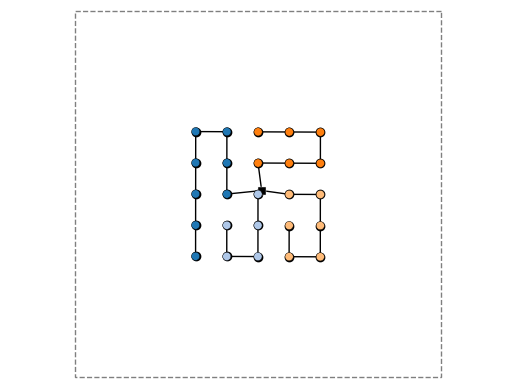

<Axes: >

In [6]:
plot_layout(
    prob, input_dict=input_dict, show_image=True, include_cable_routing=True
)